# Amazon Reviews

Stanford's [SNAP collection](https://snap.stanford.edu/data/) includes, amongst many cool and ginourmous datasets, a dataset of [~35 million amazon reviews](https://snap.stanford.edu/data/web-Amazon.html), spanning 18 years up to March 2013. (There's also an updated version of this, which now holds over 80M reviews [here](http://jmcauley.ucsd.edu/data/amazon/)) The paper this stems from - J. McAuley and J. Leskovec. [Hidden factors and hidden topics: understanding rating dimensions with review text.](http://i.stanford.edu/~julian/pdfs/recsys13.pdf) RecSys, 2013 - is well worth checking out.

My original plan was to write a paper looking at reweighting review scores based on the reviewer's rating history, but I never actually got around to it. So I thought I'd throw together a quickish blog post, walking through some of the data exploration I did get around to, and showing some of the python libraries I used in doing so.

I started off by processing the original file into something a bit more usable. For various reasons, this ended up being a two step process - first, the original file uses a sort-of-json format, so I parsed that to CSV.  The next step was to put it into something a bit faster, and I wound up using PyTables for most of this. I say most, because the HDF5 store PyTables uses makes working with strings rather an ordeal, so I settled for splitting off the actual review text into a separate file. (Actually, in a particularly stupid moment, I split the review text off into ~35 million individual files in a single directory which I'm now too afraid to open.)

While parsing to CSV, I also did two other things before throwing away the text, I collected a few stats on each review text (word and character counts, and Flesch reading ease), and ran them through a few of the scikit-learn sentiment classifiers. Of which more later.

We'll start of by loading up the data using [blaze](http://blaze.pydata.org), and getting some broad brush numbers.

In [1]:
#Import some things
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
from blaze import *
import seaborn as sns

/usr/local/lib/python2.7/site-packages/flask/exthook.py:71: ExtDeprecationWarning: Importing flask.ext.cors is deprecated, use flask_cors instead.
  .format(x=modname), ExtDeprecationWarning


In [2]:
d = Data('hdfstore://amazon.h5::df')
d

,product_price,review_time,product_productId,review_helpfulness,review_score,review_userId,review_helpfulness_outof,helpfulness_percent,log_helpfulness,BernoulliNB_prob,LinearSVC_polarity,LogisticRegression_prob,NuSVC_polarity,flesch_reading_ease,word_count,character_count
0,NaN,1182816000,B000179R3I,7,4.0,A3Q0VJTUO4EZ56,7,1.00,0.90309,1.000000,0.0,0.593016,1.0,44.07,104.0,654.0
1,17.99,1262304000,B000GKXY34,0,5.0,ADX8VLDUOL7BG,0,NaN,0.00000,0.997786,1.0,0.664168,0.0,103.63,19.0,103.0
2,17.99,1224633600,B000GKXY34,0,3.0,A3NM6P6BIWTIAE,1,0.00,0.00000,0.071008,0.0,0.278732,0.0,93.48,18.0,93.0
3,NaN,940636800,1882931173,7,4.0,AVCGYZL8FQQTD,7,1.00,0.90309,0.120601,0.0,0.162096,0.0,72.16,81.0,457.0
4,15.99,939772800,B00002066I,3,5.0,NaN,4,0.75,0.60206,0.999639,0.0,0.566449,0.0,89.75,36.0,204.0
5,15.99,1332288000,B00002066I,0,5.0,A2KLYVAS0MIBMQ,0,NaN,0.00000,0.894386,0.0,0.332627,0.0,86.71,96.0,523.0
6,NaN,1096934400,B000058A81,1,5.0,A18C9SNLZWVBIE,1,1.00,0.30103,1.000000,1.0,0.806793,1.0,62.68,225.0,1334.0
7,NaN,1088121600,B000058A81,1,5.0,A38QSOKE2DD8JD,1,1.00,0.30103,1.000000,1.0,0.954857,1.0,78.59,367.0,2071.0
8,NaN,1075939200,B000058A81,1,5.0,AKZLIIH3AP4RU,1,1.00,0.30103,1.000000,1.0,0.989603,1.0,55.58,614.0,3728.0
9,NaN,1035417600,B000058A81,1,5.0,A1FELZOGR5DEOM,1,1.00,0.30103,0.826606,0.0,0.259415,0.0,74.19,41.0,223.0


In [3]:
print "Columns are {}".format(", ".join(d.fields))
print "{:,} reviews, by {:,} reviewers, of {:,} products".format(d.shape[0], int(d.review_userId.nunique()), int(d.product_productId.nunique()))

Columns are product_price, review_time, product_productId, review_helpfulness, review_score, review_userId, review_helpfulness_outof, helpfulness_percent, log_helpfulness, BernoulliNB_prob, LinearSVC_polarity, LogisticRegression_prob, NuSVC_polarity, flesch_reading_ease, word_count, character_count
34,686,770 reviews, by 6,643,669 reviewers, of 2,441,053 products


That's a lot of reviews! The number of products, and reviewers is much lower though, which isn't that surprising - we'll have a look at how that breaks down a bit later.

## Stars, and helpfulness

We're looking at reviews, so let's start off by looking at ratings. Amazon reviews are on a 1-5 scale, so let's begin by taking a look the distribution of scores across all 34,686,770 reviews. And for kicks, compute the median and IQR.

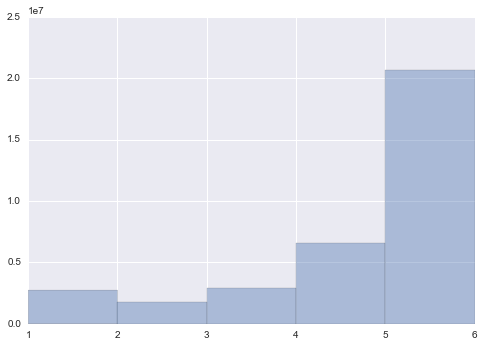

In [4]:
sns.distplot(d.review_score, bins=[1, 2, 3, 4, 5, 6], kde=False)

In [5]:
q75, median, q25 = np.percentile(d.review_score, [75, 50, 25])
print "Median is {}, and IQR is {}".format(median, q75 - q25)

Median is 5.0, and IQR is 1.0


Right away, this is pretty interesting. Amazon reviews are, going by the star ratings alone, overwhelmingly super positive. I'd expected to see a more marked bimodal peak to this - my guess is that most people don't bother to write reviews (I usually don't), so you'd guess that really they only bother if the product was really good, or really bad. The data does bear that intuition out to some extent - there's definitely less action in the lower middle ground, but the skew is very much towards the positive end.

We might also want to look at the distribution if we aggregate it by product. Because the ratings are ordinal, we should be using the median here, so we'll take advantage of pandas' groupby and aggregate methods.

In [6]:
df = into(pd.DataFrame, d[["review_score", "product_productId"]])

In [7]:
df = df.groupby("product_productId")
df = df.aggregate([np.median, np.count_nonzero])

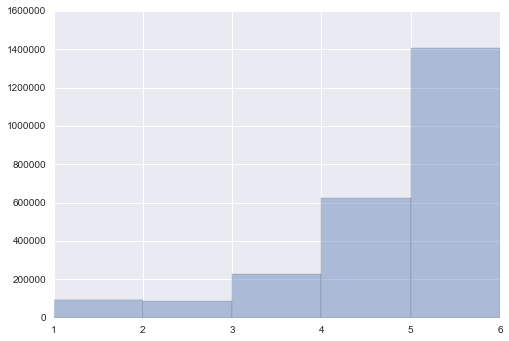

In [8]:
sns.distplot(df.review_score[["median"]], bins=[1, 2, 3, 4, 5, 6], kde=False)

This suggests that the products themselves are generally well regarded. (Wonder if this is still true given the increased role of Amazon Marketplace?)

## Watch the watchmen

The reviews themselves have ratings - people can mark them helpful, or unhelpful. Let's have a quick look at the averages for that, and then the distribution. I'm going to start with just the raw count of helpful, then we'll look it as a proportion.

In [9]:
q75, median, q25 = np.percentile(d.review_helpfulness, [75, 50, 25])
print "Median is {}, and IQR is {}".format(median, q75 - q25)

Median is 1.0, and IQR is 3.0


In [10]:
print "Mean and standard deviation are {}, and {}. Max is {}".format(float(d.review_helpfulness.mean()), float(d.review_helpfulness.std()), int(d.review_helpfulness.max()))

Mean and standard deviation are 3.71753631139, and 19.9485006603. Max is 47516


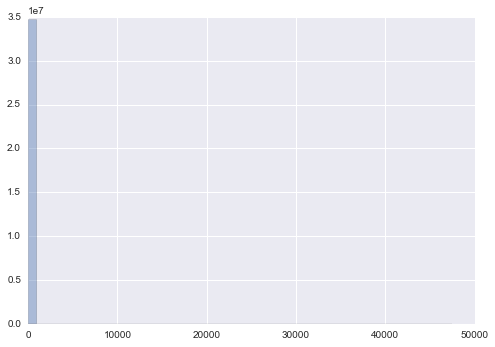

In [11]:
sns.distplot(d.review_helpfulness, kde=False)

That's... not very informative. Most reviews are evidently not very helpful. So, let's transform it to a log scale, and have another look. Because there are a lot of reviews which nobody has expressed an opinion on, I'm going to use a $\log_{10}(x+1)$ tranform.

In [12]:
d = transform(d, log_helpfulness = log10(d.review_helpfulness + 1))

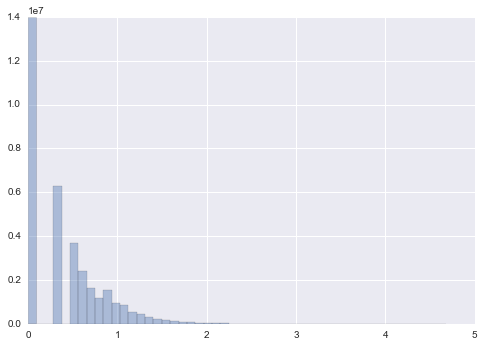

In [13]:
sns.distplot(d.log_helpfulness,kde=False)

That's more sensible. Same basic structure, most reviews aren't super helpful.

Now we'll look at helpfulness as a proportion - we have to throw away some of the reviews here (we'll check how many), because nobody cared either way about them. So, we'll plot the distribution of the proportion of helpfulness of reviews for all reviews with at least one vote.

In [14]:
nonzero = d[d.review_helpfulness_outof > 0]

In [15]:
print "There are {:,} reviews with at least one vote.".format(int(nonzero.count()))

There are 23,533,267 reviews with at least one vote.


(I'm slightly surprised by how many have a vote.)

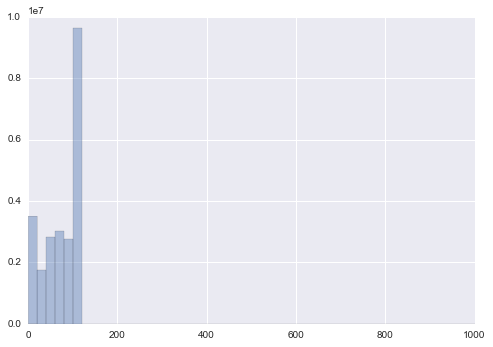

In [16]:
sns.distplot(nonzero.helpfulness_percent*100, kde=False)

Something's a bit fishy there. Obviously some reviews have ended up with more helpful votes than they have votes.. Let's see how many of these bogus records there are, and then check one out and see if I've screwed up when I converted to HDF.
We'll sort our dataset by helpfulness percentage and see what the top one looks like currently on amazon.com.

In [17]:
bogus = into(pd.DataFrame, nonzero[nonzero.helpfulness_percent > 1])
print "{:,} reviews more than 100% helpful.".format(len(bogus.index))
bogus.sort("helpfulness_percent", ascending=False).iloc[0]

86 reviews more than 100% helpful.


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


product_price                        24.35
review_time                     1084665600
product_productId               0471655430
review_helpfulness                      10
review_score                             5
review_userId               A11ADAS327TWKY
review_helpfulness_outof                 1
helpfulness_percent                     10
BernoulliNB_prob                         1
LinearSVC_polarity                       1
LogisticRegression_prob           0.656577
NuSVC_polarity                           1
flesch_reading_ease                  62.68
word_count                             276
character_count                       1570
log_helpfulness                    1.04139
Name: 33225, dtype: object

Ok, first off - there are only 86 of these. That's a drop in the ocean, and incidentally something we can comfortably work with in memory, so I've popped the bogus reviews into a dataframe for the next bit.

The review in question is [this one](http://www.amazon.com/gp/customer-reviews/R1G1S9ZGU97CIU), by one Gerald J Palmer, of Maui. (Hi Gerald, how's Maui?)

Gerald's review, of John Maudlin's *Bull's Eye Investing: Targeting Real Returns in a Smoke and Mirrors Market*, is 1000% helpful, according to my dataset. I can see why he only wrote one review - how do you top that?

But when I pulled it up, it actually didn't have any votes either way:

<img src="palmer_review.png" />

Which doesn't look great for my scripting. But, despite only having written this review, Gerald is actually 77% helpful:

<img src="palmer_record.png" />

Which is odd. So we'll have a quick look at a few more of the reviews with odd helpfulness ratings.

In [18]:
bogus.sort("helpfulness_percent", ascending=False).iloc[:10]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,product_price,review_time,product_productId,review_helpfulness,review_score,review_userId,review_helpfulness_outof,helpfulness_percent,BernoulliNB_prob,LinearSVC_polarity,LogisticRegression_prob,NuSVC_polarity,flesch_reading_ease,word_count,character_count,log_helpfulness
33225,24.35,1084665600,0471655430,10,5.0,A11ADAS327TWKY,1,10.0,1.000000,1.0,0.656577,1.0,62.68,276.0,1570.0,1.041393
23447,3.95,1081900800,B0095T9N78,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243
29972,NaN,1081900800,6302259428,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243
36629,2.95,1081900800,B000FT9NDG,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243
27922,2.95,1081900800,B0001LJCRU,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243
22839,NaN,1078444800,B00005X3N6,7,5.0,A12D627OBD862T,1,7.0,1.000000,1.0,0.928627,1.0,64.71,60.0,365.0,0.903090
11607,NaN,1081382400,B00004TDNV,7,1.0,A1B7HB2XV9GRJP,1,7.0,0.006076,0.0,0.234706,0.0,86.71,63.0,355.0,0.903090
42384,NaN,1078444800,0786119551,7,5.0,A12D627OBD862T,1,7.0,1.000000,1.0,0.928627,1.0,64.71,60.0,365.0,0.903090
39778,NaN,1078444800,0453003699,7,5.0,A12D627OBD862T,1,7.0,1.000000,1.0,0.928627,1.0,64.71,60.0,365.0,0.903090
18716,NaN,1078444800,B0006RF9DU,7,5.0,A12D627OBD862T,1,7.0,1.000000,1.0,0.928627,1.0,64.71,60.0,365.0,0.903090


A bunch of these are by the same few people for example, Tommy, or A14VQ55F6O49C1, as I like to call him. The first one is a review of [the Ilsa Collection](http://www.amazon.com/dp/B0001LJCRU), which is a set of grindhouse movies. (Tommy wasn't blown away by them, and his review is 800% helpful so I guess I won't put them on my Netflix list.) Like the first review I checked, this too has no votes.

Quite a few of the others don't seem to exist anymore, and unfortunately [archive.org](http://archive.org) doesn't crawl amazon reviews. At this point, I went back and hunted down one of the reviews in my source dataset to check I hadn't screwed up the importing (I hadn't).

Out of curiosity, I thought I'd check to see when these reviews actually happened.

In [19]:
bogus

,product_price,review_time,product_productId,review_helpfulness,review_score,review_userId,review_helpfulness_outof,helpfulness_percent,BernoulliNB_prob,LinearSVC_polarity,LogisticRegression_prob,NuSVC_polarity,flesch_reading_ease,word_count,character_count,log_helpfulness
8612,NaN,1008892800,1930771142,2,5.0,A1VYC3XNQU72RF,1,2.0,0.990855,0.0,0.434846,0.0,56.25,45.0,274.0,0.477121
39075,NaN,1098662400,B00004SFZ3,4,5.0,AKURIEO6PHTDY,2,2.0,0.986497,1.0,0.651031,0.0,90.09,124.0,684.0,0.698970
47403,2.99,1190073600,B000FGGLCK,2,5.0,A3GJYJFNNEFO0C,1,2.0,0.999998,1.0,0.843200,1.0,70.13,181.0,1036.0,0.477121
43937,NaN,1081382400,B00004TCPO,7,1.0,A1B7HB2XV9GRJP,1,7.0,0.006076,0.0,0.234706,0.0,86.71,63.0,355.0,0.903090
46347,NaN,1081382400,B00004TCPM,7,1.0,A1B7HB2XV9GRJP,1,7.0,0.006076,0.0,0.234706,0.0,86.71,63.0,355.0,0.903090
13382,NaN,1236470400,0743507770,2,5.0,A18ZOHJ7ZERQ8,1,2.0,1.000000,1.0,0.869301,1.0,61.67,318.0,1904.0,0.477121
41292,19.99,1231200000,B001NFWSCE,2,5.0,A2MSIK8DWUSDTJ,1,2.0,0.998548,0.0,0.327971,0.0,83.66,103.0,583.0,0.477121
29972,NaN,1081900800,6302259428,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243
11330,NaN,1191196800,B00005NJFG,2,4.0,ANCOMAI0I7LVG,1,2.0,1.000000,1.0,0.958338,1.0,59.64,443.0,2629.0,0.477121
27922,2.95,1081900800,B0001LJCRU,8,3.0,A14VQ55F6O49C1,1,8.0,0.278675,0.0,0.467559,0.0,75.20,116.0,655.0,0.954243


In [20]:
from time import gmtime, strftime

earliest = bogus.review_time.min()
latest = bogus.review_time.max()

print "Bogus reviews occurred between {}, and {}.".format(strftime("%a, %d %b %Y", gmtime(earliest)), 
                                                          strftime("%a, %d %b %Y", gmtime(latest)))

print "Most recent was by {review.review_userId} of {review.product_productId}".format(review=bogus.sort("review_time", ascending=False).iloc[0])

Bogus reviews occurred between Thu, 23 Dec 1999, and Sun, 10 May 2009.
Most recent was by A26QHGZ5AYSTU5 of B000FKPEF6


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


And that last one also has zero votes either way.
So, who knows? Either a hiccup in collating the original dataset, or at some point amazon's data was screwed up. Either way, I'm happy to throw out those 86 reviews, as long as you guys are. 

Let's finally take a look at the distribution.

In [21]:
nonzero = nonzero[nonzero.helpfulness_percent <= 1]

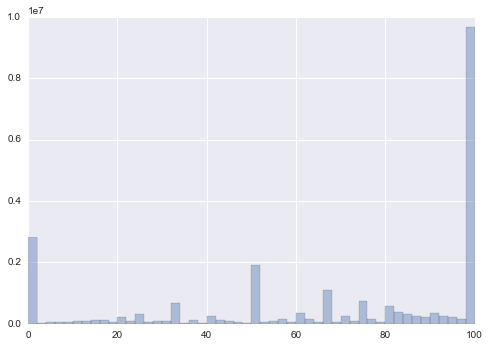

In [22]:
sns.distplot(nonzero.helpfulness_percent*100, kde=False)

So this is more or less what you'd expect - most reviews that people expressed an opinion on, they think were helpful. There are peaks around totally unhelpful, and the contentious middle ground.

How about the relationship between helpfulness and star ratings? I don't know about you, but I tend to only look at the extreme ends of the scale when I'm considering a product. Let's start off by looking at a boxplot of helpfulness against star rating.

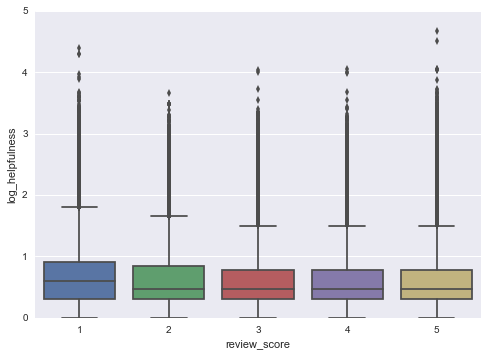

In [23]:
sns.boxplot(data=into(pd.DataFrame, nonzero[["log_helpfulness", "review_score"]]), x="review_score", y="log_helpfulness", order=[1,2,3,4,5])

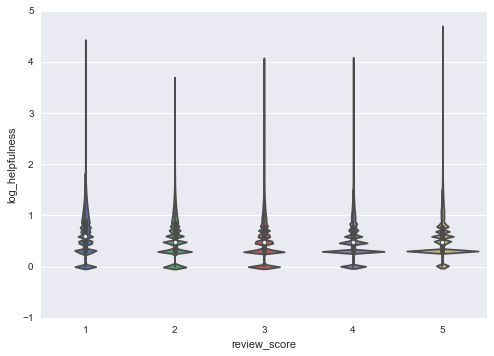

In [24]:
sns.violinplot(data=into(pd.DataFrame, nonzero[["log_helpfulness", "review_score"]]), x="review_score", y="log_helpfulness", order=[1,2,3,4,5])

Now, I don't think this is actually that clear cut. 1, and 5 star reviews definitely have more super helpful reviews

Another possibility is that it isn't so much that the extremes are more *helpful*, but that they attract more *attention*. 

Here's the same plot, but for unhelpfulness. (Obviously, since we've thrown out the reviews with zero votes, we don't need the +1 in the transform, but I'll leave it in for consistency with the transformed helpfulness data.)

In [25]:
nonzero = transform(nonzero, log_unhelpfulness = log10((nonzero.review_helpfulness_outof - nonzero.review_helpfulness) + 1))

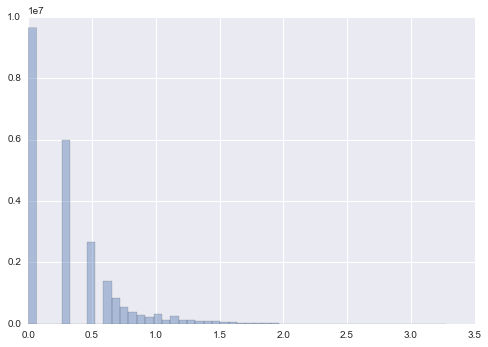

In [26]:
sns.distplot(nonzero.log_unhelpfulness, kde=False)

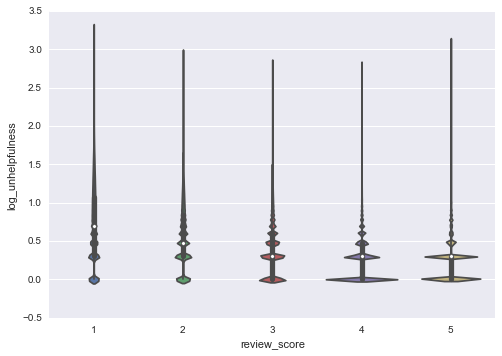

In [27]:
sns.violinplot(data=into(pd.DataFrame, nonzero[["log_unhelpfulness", "review_score"]]), x="review_score", y="log_unhelpfulness", order=[1,2,3,4,5])

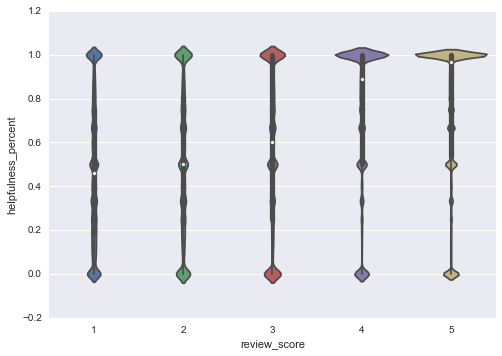

In [28]:
sns.violinplot(data=into(pd.DataFrame, nonzero[["helpfulness_percent", "review_score"]]), x="review_score", y="helpfulness_percent", order=[1,2,3,4,5])

But if we look at the unhelpfulness, we can take a guess that this is as much down to the extremes attracting more attention as anything. But with this much data, we should be able to do better than just *guess*. 

Let's start by checking our eyeballing of the graphs. What I'm going to try here, is fitting a multinomial logit model, with review score as the dependent variable. We'll start off with the raw counts for helpfulness, unhelpfulness, and votes as the predictor. My theory being, that if extremes really are more helpful, that should show up in the coefficient for helpfulness.

On the other hand, if they just attract attention I'm expecting to see that reflected in the raw count. Finally, there might just not be much of a relationship (or a more nuanced one) and we'll see crappy model fit, or funky coefficients.

Sit tight, we're about to attempt to run a regression on 23,533,180 observations. This may take a while..

In [29]:
nonzero = transform(nonzero, unhelpfulness=(nonzero.review_helpfulness_outof - nonzero.review_helpfulness))

In [30]:
from statsmodels.discrete.discrete_model import MNLogit

%time scores_model = MNLogit.from_formula(formula="C(review_score) ~ unhelpfulness + review_helpfulness + review_helpfulness_outof + helpfulness_percent", data=into(pd.DataFrame, nonzero[["unhelpfulness", "review_helpfulness", "review_helpfulness_outof", "helpfulness_percent", "review_score"]]))
%time scores_model_results = scores_model.fit()
scores_model_results.summary()

CPU times: user 2min 53s, sys: 21.5 s, total: 3min 15s
Wall time: 4min 45s


/usr/local/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:580: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  start_params = np.zeros((self.K * (self.J-1)))
/usr/local/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1840: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/usr/local/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1756: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')
/usr/local/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:1697: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  params = params.reshape(self.K, -1, order='F')


         Current function value: 1.183075
         Iterations: 35


/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/discrete/discrete_model.py:588: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mnfit.params = mnfit.params.reshape(self.K, -1, order='F')


CPU times: user 11min 31s, sys: 6min 6s, total: 17min 37s
Wall time: 17min 30s


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:             23533181
Model:                        MNLogit   Df Residuals:                 23533165
Method:                           MLE   Df Model:                           12
Date:                Fri, 09 Sep 2016   Pseudo R-squ.:                 0.06409
Time:                        13:43:45   Log-Likelihood:            -2.7842e+07
converged:                      False   LL-Null:                   -2.9748e+07
                                        LLR p-value:                     0.000
============================================================================================
  y=C(review_score)[2.0]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   -0.2499      0.002   -114.262      0.000        -0.254    -0.246
unhelpfulness               -0.0214    282.191  -7.59e-05      1.000      -553.106   553.063
review_helpfulness           0.0117    282.191   4.14e-05      1.000      -553.072   553.096
review_helpfulness_outof    -0.0096    282.191  -3.41e-05      1.000      -553.094   553.074
helpfulness_percent         -0.0759      0.003    -23.719      0.000        -0.082    -0.070
--------------------------------------------------------------------------------------------
  y=C(review_score)[3.0]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    0.2683      0.002    126.419      0.000         0.264     0.272
unhelpfulness               -0.0580    328.093     -0.000      1.000      -643.108   642.992
review_helpfulness           0.0320    328.093   9.74e-05      1.000      -643.018   643.082
review_helpfulness_outof    -0.0261    328.093  -7.94e-05      1.000      -643.076   643.024
helpfulness_percent         -0.0088      0.003     -2.998      0.003        -0.015    -0.003
--------------------------------------------------------------------------------------------
  y=C(review_score)[4.0]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    0.7539      0.002    354.582      0.000         0.750     0.758
unhelpfulness               -0.1393     85.588     -0.002      0.999      -167.889   167.611
review_helpfulness           0.0751     85.588      0.001      0.999      -167.675   167.825
review_helpfulness_outof    -0.0645     85.588     -0.001      0.999      -167.814   167.685
helpfulness_percent          0.6459      0.003    234.022      0.000         0.641     0.651
--------------------------------------------------------------------------------------------
  y=C(review_score)[5.0]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                    1.6437      0.002    910.958      0.000         1.640     1.647
unhelpfulness               -0.1393        nan        nan        nan           nan       nan
review_helpfulness           0.0766        nan        nan        nan           nan       nan
review_helpfulness_outof    -0.0637        nan        nan        nan           nan       nan
helpfulness_percent          0.9277      0.002    382.976      0.000         0.923     0.932
============================================================================================
"""

Well that will teach me to be cynical! Percentage helpfulness is really the only coefficient worth looking at here, and it backs up what we saw in the boxplots, namely that positive reviews are more helpful. The raw counts don't get much of a look in, which to me suggests that the helpfulness of a review isn't that much to do with it having an extreme star rating.

## Getting Sentimental

I've also run the actual text of all the reviews through four sentiment analysis models, all of which were trained on scikit-learn's movie reviews dataset.

Our four classifiers are BernoulliNB_prob, LinearSVC_polarity, LogisticRegression_prob, NuSVC_polarity. (Nowadays, I'd probably include a DNN, and xgboost here, and build a classifier ensemble using caret, or H2O)

First off, how many reviews did each classifier think were positive?

In [31]:
d = transform(d, bernoulli_polarity = d.BernoulliNB_prob.map(np.round, 'float64'), lr_polarity = d.LogisticRegression_prob.map(np.round, 'float64'))

In [32]:
rowcount = d.nrows
bnb_pos = float(d.bernoulli_polarity.sum())/rowcount
lr_pos = float(d.lr_polarity.sum())/rowcount
nusvc_pos = float(d.NuSVC_polarity.sum())/rowcount
cv_pos = float(d.LinearSVC_polarity.sum())/rowcount

In [33]:
"BernoulliNB_prob {}, LinearSVC_polarity {}, LogisticRegression_prob {}, NuSVC_polarity {}".format(bnb_pos, cv_pos, lr_pos, nusvc_pos)

'BernoulliNB_prob 30229662.0 / (nelements(Merge(_child=_1, children=(Merge(_child=_1, children=(_1[[\'product_price\', \'review_time\', \'product_productId\', \'review_helpfulness\', \'review_score\', \'review_userId\', \'review_helpfulness_outof\', \'helpfulness_percent\', \'BernoulliNB_prob\', \'LinearSVC_polarity\', \'LogisticRegression_prob\', \'NuSVC_polarity\', \'flesch_reading_ease\', \'word_count\', \'character_count\']], label(log10(_1.review_helpfulness + 1), \'log_helpfulness\'))), Map(_child=_1.BernoulliNB_prob, func=numpy.core.fromnumeric.round_, _asschema=dshape("float64"), _name0=\'bernoulli_polarity\'), Map(_child=_1.LogisticRegression_prob, func=numpy.core.fromnumeric.round_, _asschema=dshape("float64"), _name0=\'lr_polarity\'))))), LinearSVC_polarity 18676344.0 / (nelements(Merge(_child=_1, children=(Merge(_child=_1, children=(_1[[\'product_price\', \'review_time\', \'product_productId\', \'review_helpfulness\', \'review_score\', \'review_userId\', \'review_helpfulnes

There seems to be some debate about how positive the amazon reviewers are. We'll calculate the Jaccard similarity measure for each pair of classifiers, to see how in agreement they are.

In [34]:
from sklearn.metrics import jaccard_similarity_score
import itertools

polarities = ["bernoulli_polarity", "lr_polarity", "NuSVC_polarity", "LinearSVC_polarity"]

In [35]:
df = into(pd.DataFrame, d[polarities + ["review_score"]]).dropna()

for x, y in itertools.combinations(polarities, 2):
    jaccard = jaccard_similarity_score(df[x].astype(int), df[y].astype(int))
    print "Jaccard score for {} and {} = {}".format(x, y, jaccard)

Jaccard score for bernoulli_polarity and lr_polarity = 0.703281777246
Jaccard score for bernoulli_polarity and NuSVC_polarity = 0.487277275931
Jaccard score for bernoulli_polarity and LinearSVC_polarity = 0.637187786439
Jaccard score for lr_polarity and NuSVC_polarity = 0.755562339445
Jaccard score for lr_polarity and LinearSVC_polarity = 0.909060905497
Jaccard score for NuSVC_polarity and LinearSVC_polarity = 0.798463096316


Ok, so it looks like Bernoulli may have rose tinted glasses on here. We'll also take a quick look at how the models classify the sentiment of different star ratings.

In [36]:
df = into(pd.DataFrame, d[polarities + ["review_score"]]).dropna()
df

,bernoulli_polarity,lr_polarity,NuSVC_polarity,LinearSVC_polarity,review_score
0,1.0,1.0,1.0,0.0,4.0
1,1.0,1.0,0.0,1.0,5.0
2,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,4.0
4,1.0,1.0,0.0,0.0,5.0
5,1.0,0.0,0.0,0.0,5.0
6,1.0,1.0,1.0,1.0,5.0
7,1.0,1.0,1.0,1.0,5.0
8,1.0,1.0,1.0,1.0,5.0
9,1.0,0.0,0.0,0.0,5.0


In [37]:
dx = pd.melt(df, id_vars=["review_score"])

In [38]:
dx.groupby(["variable", "review_score"]).mean()

value
variable           review_score          
LinearSVC_polarity 1.0           0.200650
                   2.0           0.280589
                   3.0           0.431647
                   4.0           0.594207
                   5.0           0.602810
NuSVC_polarity     1.0           0.074333
                   2.0           0.138004
                   3.0           0.276114
                   4.0           0.426402
                   5.0           0.416016
bernoulli_polarity 1.0           0.514642
                   2.0           0.647367
                   3.0           0.812502
                   4.0           0.915535
                   5.0           0.932544
lr_polarity        1.0           0.220494
                   2.0           0.301313
                   3.0           0.469947
                   4.0           0.655864
                   5.0           0.686133

Right away we can see the optimistic world view of the Bernoulli classifier in action - over half the 1 star reviews are positive. In fact, aside from NuSVC, all the classifiers think that there are more positive 1 star reviews than you might expect. Otherwise, this looks right - higher stars, more positive text.

We can, once again fit some MNLogit models to look at the relationship. (Because the Bernoulli and Logistic regression models are actually forecasting probablistically, I'm going to use them in that capacity here.)

In [39]:
from statsmodels.discrete.discrete_model import MNLogit
df = into(pd.DataFrame, d[["review_score", "BernoulliNB_prob", "LogisticRegression_prob",  "NuSVC_polarity", "LinearSVC_polarity"]]).dropna()
for model in ["BernoulliNB_prob", "LogisticRegression_prob", "NuSVC_polarity", "LinearSVC_polarity"]:
    model = model if "prob" in model else "C({})".format(model)
    formula = "C(review_score) ~ {}".format(model)
    print model
    %time sent_model = MNLogit.from_formula(formula=formula, data=df)
    %time sent_model_results = sent_model.fit()
    print sent_model_results.summary()
    print ""

BernoulliNB_prob
CPU times: user 2min 16s, sys: 4.36 s, total: 2min 20s
Wall time: 2min 22s
Optimization terminated successfully.
         Current function value: 1.118068
         Iterations 7
CPU times: user 2min 46s, sys: 1min 22s, total: 4min 8s
Wall time: 4min 10s
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:             34686754
Model:                        MNLogit   Df Residuals:                 34686746
Method:                           MLE   Df Model:                            4
Date:                Fri, 09 Sep 2016   Pseudo R-squ.:                 0.05551
Time:                        14:36:11   Log-Likelihood:            -3.8782e+07
converged:                       True   LL-Null:                   -4.1061e+07
                                        LLR p-value:                     0.000
y=C(review_score)[2.0]       coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------

Horrible model fits, but they say more or less what you'd expect - more likely to give stars if your text parsed as more positive. (We could also try the inverse of this process, and train the classifiers using the Amazon reviews as the corpus, but that's a different topic altogether.)

While we're at it, I'm also curious about whether there's a relationship between a review being helpful, and the sentiment of it. We'd expect there to be at least a hint of something here, because we already know positive reviews are more helpful.

In [ ]:
df = into(pd.DataFrame, d[polarities + ["helpfulness_percent"]]).dropna()

In [59]:
dl = pd.melt(df[df.helpfulness_percent <= 1], id_vars=["helpfulness_percent"])

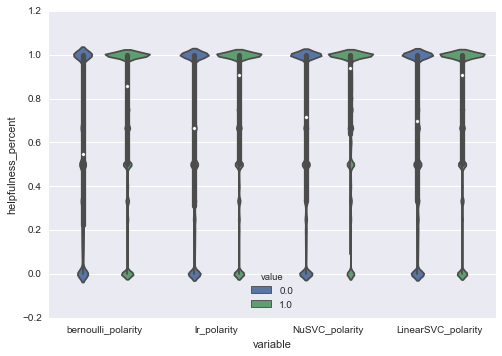

In [60]:
sns.violinplot(data=dl, x="variable", y="helpfulness_percent", hue="value")

## Readability

Last, but not least, I've used the textstat module to calculate Flesch reading ease scores, for all of the review texts.

In [61]:
print "Mean Flesch reading ease score is {}, with a standard deviation of {}".format(float(d.flesch_reading_ease.mean()), float(d.flesch_reading_ease.std()))

Mean Flesch reading ease score is 72.9771985245, with a standard deviation of 15.7251010374


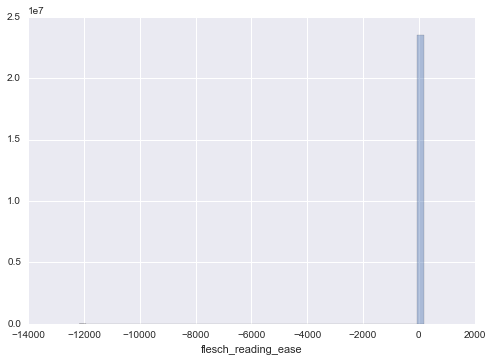

In [62]:
df = into(pd.DataFrame, d[["flesch_reading_ease", "review_score", "helpfulness_percent"]]).dropna()
sns.distplot(df.flesch_reading_ease, kde=False)

Well evidently there are some unimaginably unreadable reviews. Let's try excluding some..

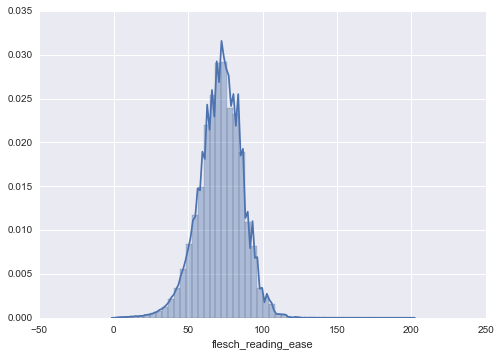

In [63]:
sns.distplot(df[df.flesch_reading_ease >= 0].flesch_reading_ease)

Much better. That's pretty much normally distributed about the mean of 72, which is pretty easy reading. Unsurprising, given the brevity of the format.

Is people's eloquence related to the star rating you ask? Let's have a look.

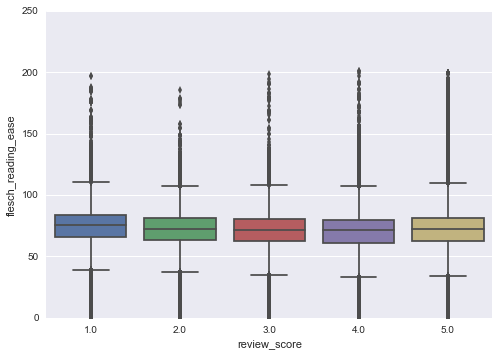

In [ ]:
sns.boxplot(data=df[df.flesch_reading_ease >= 0], y="flesch_reading_ease", x="review_score")

Not strongly, it seems. How about how helpful the review is? I'm kind of expecting helpful reviews to be easier reading, but I don't think it will be quite that simple. My gut feeling is that while some reviews are useful because they're really *detailed*, some will be helpful because they're really *clear*.

In [ ]:
sns.jointplot(kind="kde", data=df[(df.flesch_reading_ease >= 0) & (df.helpfulness_percent <= 1)], x="flesch_reading_ease", y="helpfulness_percent")

Finally, I'm curious about how readable the reviews are vs whether they're positive or negative. We'll have a quick peek at the logistic regression classifier. You'd also expect the readablity to relate to how good a job the classifier does here, so I'm guessing this will be murky.